# Frequency Analysis
Based on: Social Media Analytics – Introduction to Text Mining – Frequency Analysis

by (c) Nuno Antonio 2019-2021

### Initial setup

In [1]:
# Import packages
import csv
import pandas as pd
import numpy as np
import nltk 
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

from emot.emo_unicode import UNICODE_EMO, EMOTICONS
import emoji

In [2]:
# Load dataset
base_path = "Data/"
ds = pd.read_excel(base_path + "Tweets_cleaned.xlsx")

### Functions

In [3]:
# Replace emojis and smileys

# Converting emojis to words
# Using both emot and emoji package to cover missing emojis
def convert_emojis(text):
    # from https://towardsdatascience.com/text-preprocessing-for-data-scientist-3d2419c8199d
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))

    emoji.demojize(text, delimiters=("", "")) 
    return text
# Converting emoticons to words   
# from https://towardsdatascience.com/text-preprocessing-for-data-scientist-3d2419c8199d 
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

def remove_emoji(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "")
    return text

def remove_emoticon(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "", text)
    return text

In [4]:
# Text preprocessing
def textPreProcess(rawText, removeHTML=True, charsToRemove = r'\?|\.|\!|\;|\.|\"|\,|\(|\)|\&|\:|\-', removeNumbers=True, removeLineBreaks=False, specialCharsToRemove = r'[^\x00-\xfd]', convertToLower=True, removeConsecutiveSpaces=True, convert_emojis=False, remove_emojis = False):
    cleanedText = []
    for x in (rawText[:]): 
        
        if type(x) != str:
            print("Type: ", str(type(x)))
            x = str(x)
        
        # Remove HTML
        if removeHTML:
            procText = BeautifulSoup(x,'html.parser').get_text()

        if convert_emojis:
            procText = convert_emojis(procText)
            procText = convert_emoticons(procText)
        
        if remove_emojis:
            procText = remove_emoji(procText)
            procText = remove_emoticon(procText)

         # Remove punctuation and other special characters
        if len(charsToRemove)>0:
            procText = re.sub(charsToRemove,' ',procText)

        # Remove numbers
        if removeNumbers:
            procText = re.sub(r'\d+',' ',procText)

        # Remove line breaks
        if removeLineBreaks:
            procText = procText.replace('\n',' ').replace('\r', '')

        # Remove special characters
        if len(specialCharsToRemove)>0:
            procText = re.sub(specialCharsToRemove,' ',procText)

        # Normalize to lower case
        if convertToLower:
            procText = procText.lower() 

        # Replace multiple consecutive spaces with just one space
        if removeConsecutiveSpaces:
            procText = re.sub(' +', ' ', procText)


        cleanedText.append(procText)


    return cleanedText

In [5]:
# Tokenize texts
def tokenize_words(texts):
    words_new = []
    for w in (texts[:]):
        w_token = word_tokenize(w)
        if w_token != '':
            words_new.append(w_token)
    return words_new

In [6]:
# Stemm texts
def stemming(words):
    procText = []
    for w in (words[:]):
        stemmed_word = [snowball.stem(x) for x in (w[:])]
        procText.append(stemmed_word)
    return procText

In [7]:
# Function to count the frequency of n-grams (Adapted from https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34)
# Uses CountVectorizer from sklearn instead of FreqDist from NLTK
def get_top_n_words(corpus, n=None, nGrams=1): 
    vec = CountVectorizer(max_df=0.8, stop_words=stop_words,ngram_range=(nGrams,nGrams), max_features=10000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### Analysis

In [8]:
# Create a dataframe with only the description
processedTweets =  pd.DataFrame(data=textPreProcess(ds.text, removeLineBreaks=True, removeNumbers=True, convertToLower=True, convert_emojis=False, remove_emojis=True), columns=['PreProcessedText']) 

Type:  <class 'int'>


In [9]:
# Tokenize text
processedTweets['Words'] =  tokenize_words(processedTweets['PreProcessedText'])

In [10]:
# Compute terms frequency distribution
from nltk.probability import FreqDist
fdist = FreqDist()
for review in processedTweets.Words:
  for term in review:
    fdist[term]+=1

In [11]:
# Transform results to a sorted dataframe
df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
df_fdist.columns = ['Frequency']
df_fdist.index.name = 'Term'
df_fdist = df_fdist.sort_values(by='Frequency', ascending=False)

In [12]:
# Remove stopwords and re-explore results
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df_fdist = df_fdist[~df_fdist.index.isin(stop_words)]
df_fdist.head(15)

,Frequency
Term,
vaccine,19831
get,4689
people,4477
covid,4132
n't,3440
vaccination,3033
's,2872
us,2272
world,2162


In [13]:
# Create a stemmed version of the words to normalize the Lexicon
# Import package
from nltk.stem import SnowballStemmer

In [14]:
# Check languages supported
print(" ".join(SnowballStemmer.languages))

arabic danish dutch english finnish french german hungarian italian norwegian porter portuguese romanian russian spanish swedish


In [15]:
# Do stemming
snowball = SnowballStemmer("english")
# Create a new column for stemm words
processedTweets['StemmedWords'] = stemming(processedTweets['Words']) 

In [16]:
# Calculate frequency distributions of the stemmed words
fdist = FreqDist()
for tweet in processedTweets.StemmedWords:
  for term in tweet:
    fdist[term]+=1

# Create the sorted dataframe and sort it
df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
df_fdist.columns = ['Frequency']
df_fdist.index.name = 'Term'
df_fdist = df_fdist.sort_values(by='Frequency', ascending=False)

In [17]:
# Remove the stopwords
df_fdist = df_fdist[~df_fdist.index.isin(stop_words)] 

[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

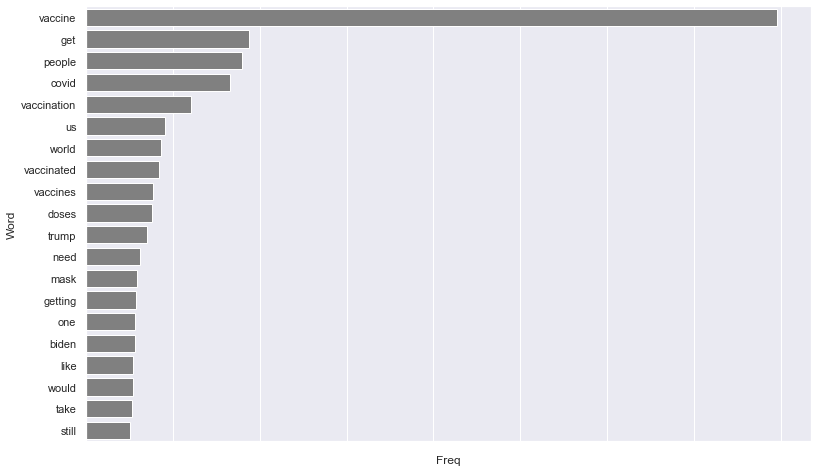

In [29]:
# PLOT top 20 most frequently occuring UNI-GRAMS
top_words = get_top_n_words(processedTweets['PreProcessedText'], n=20, nGrams=1)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

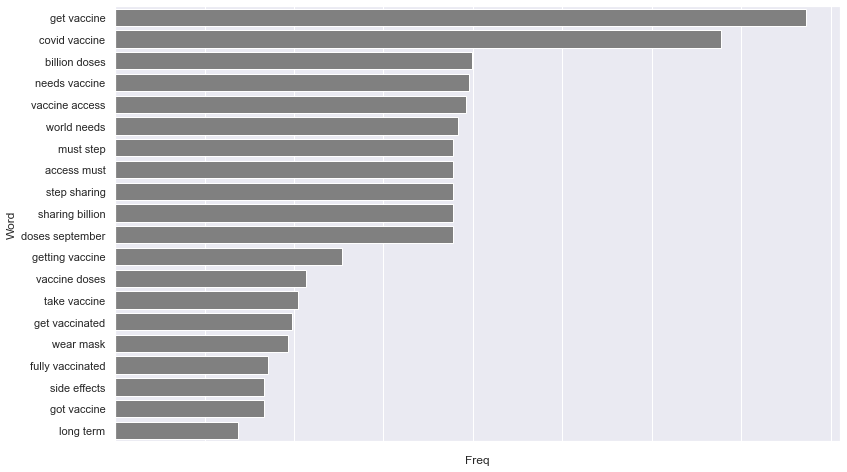

In [30]:
# PLOT top 20 most frequently occuring BI-GRAMS
top_words = get_top_n_words(processedTweets['PreProcessedText'], n=20, nGrams=2)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

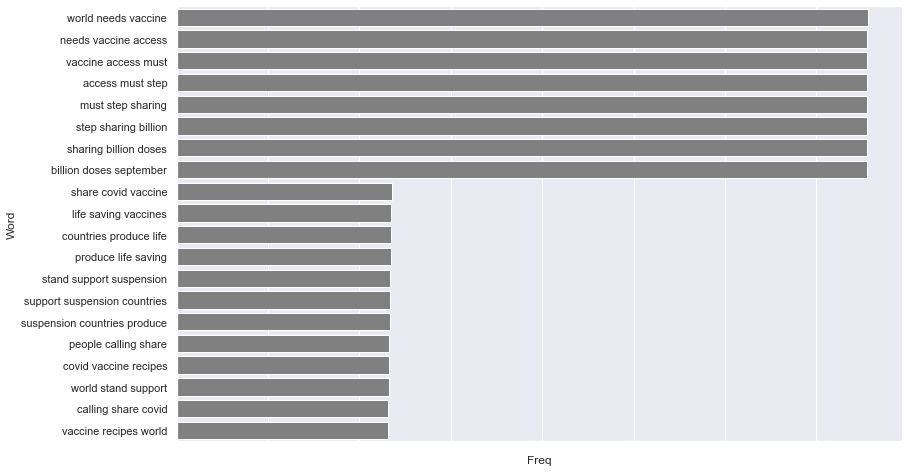

In [32]:
# PLOT top 20 most frequently occuring TRI-GRAMS
top_words = get_top_n_words(processedTweets['PreProcessedText'], n=20, nGrams=3)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

"Veja dicas sobre" and "dicas sobre quartos" is text added to the desciption by Tripadvisor to lead users to read more about the hotel. Therefore, this text should be removed from the description in the preprocessing phase.